We are use the popular Flights Dataset to analyze and predict flight delays in airports based on past flight records. 
For this dataset, we will only look at the flights in 2014 .
Model used is Logistic Regression

# Import findspark and findspark.init() to make pyspark importable as a regular library

In [1]:
import findspark 
findspark.init() 
findspark.find() 
import pyspark 
findspark.find()

'c:\\Users\\markj\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\pyspark'

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

#importing some packages we need

In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
import pyarrow as pa
from pyarrow import csv
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%matplotlib inline

Removing headers of the dataset and renaming it so that further it will be easier for us analyse 

In [7]:
textFile = sc.textFile('2014_12.csv')
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()
textRDD = textFileRDD.filter(lambda r: r != header)

# Creating the Dataframe from RDD (Resilient Distributed Dataset)

In [9]:
def parse(r):
    try:
        x=Row(Year=int(r[0]),\
          Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          DepTime=int(float(r[8])), \
          CRSDepTime=int(r[7]),\
          ArrTime=int(float(r[11])),\
          CRSArrTime=int(r[10]), \
          UniqueCarrier=r[4],\
          DepDelay=int(float(r[9])),\
          Origin=r[5],\
          Dest=r[6], \
          Distance=int(float(r[12])),\
          CarrierDelay=int(float(r[13])),\
          WeatherDelay=int(float(r[14])),\
          NASDelay= int(float(r[15])),\
          SecurityDelay=int(float(r[16])),\
          LateAircraftDelay=int(float(r[17])))  
    except:
        x=None  
    return x

rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
sqlContext = SQLContext(sc)
airline_df = sqlContext.createDataFrame(rowRDD)

DepDelayed is a new column added to dataframe 

True for delay > 15 minutes 

False for delay <=15 minutes

In [10]:
airline_df = airline_df.withColumn('DepDelayed', airline_df['DepDelay']>15)

In [11]:
# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF 
sqlContext.udf.register("hour_ex_py",hour_ex, IntegerType())
f_udf = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f_udf(airline_df.CRSDepTime))
airline_df.registerTempTable("airlineDF")

c:\Users\markj\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [12]:
airline_df.head(n=5)

[Row(Year=2014, Month=12, DayofMonth=9, DayOfWeek=2, DepTime=1113, CRSDepTime=1050, ArrTime=1329, CRSArrTime=1310, UniqueCarrier='AA', DepDelay=23, Origin='DFW', Dest='MSP', Distance=852, CarrierDelay=0, WeatherDelay=0, NASDelay=0, SecurityDelay=0, LateAircraftDelay=19, DepDelayed=True, hour=10),
 Row(Year=2014, Month=12, DayofMonth=12, DayOfWeek=5, DepTime=1057, CRSDepTime=1050, ArrTime=1332, CRSArrTime=1310, UniqueCarrier='AA', DepDelay=7, Origin='DFW', Dest='MSP', Distance=852, CarrierDelay=2, WeatherDelay=0, NASDelay=15, SecurityDelay=0, LateAircraftDelay=5, DepDelayed=False, hour=10),
 Row(Year=2014, Month=12, DayofMonth=20, DayOfWeek=6, DepTime=1143, CRSDepTime=1050, ArrTime=1400, CRSArrTime=1310, UniqueCarrier='AA', DepDelay=53, Origin='DFW', Dest='MSP', Distance=852, CarrierDelay=3, WeatherDelay=0, NASDelay=0, SecurityDelay=0, LateAircraftDelay=47, DepDelayed=True, hour=10),
 Row(Year=2014, Month=12, DayofMonth=22, DayOfWeek=1, DepTime=1105, CRSDepTime=1050, ArrTime=1330, CRSAr

# Exploration: What are the primary causes for flight delays

In [13]:
cause_delay = sqlContext.sql("SELECT sum(WeatherDelay) Weather,sum(NASDelay) NAS,sum(SecurityDelay) Security,sum(LateAircraftDelay) lateAircraft,sum(CarrierDelay) Carrier\
                              FROM airlineDF ")

In [14]:
df_cause_delay = cause_delay.toPandas()
df_cause_delay.head()

,Weather,NAS,Security,lateAircraft,Carrier
0,141765,1416790,7130,2519320,1866220


# Exploration: Which Airports have the Most Delays?

In [15]:
groupedDelay = sqlContext.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay \
                                FROM airlineDF \
                                GROUP BY Origin")

df_origin = groupedDelay.toPandas()
df_origin.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay
89,BJI,6,143.500000
20,MQT,9,130.888889
197,GUC,25,124.960000
33,HLN,9,119.222222
72,RDD,29,114.413793


Mapping each Airport to corresponding Long and Lat,load the dataset needed from "airport.dat"

In [16]:
df = pd.read_csv('airports.dat', index_col=0,\
names = ['name', 'city', 'country','IATA','ICAO','lat','lng','alt','TZone','DST','Tz','air','Ourair'], \
            header=0)
del df['air']
del df['Ourair']
df.head()

,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby
6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby


In [21]:
df_airports = pd.merge(df_origin, df, left_on = 'Origin', right_on = 'IATA')
df_airports.head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
0,INL,13,41.692308,Falls International Airport,International Falls,United States,INL,KINL,48.566200,-93.403099,1185,-6,A,America/Chicago
1,PSE,2,38.500000,Mercedita Airport,Ponce,Puerto Rico,PSE,TJPS,18.008301,-66.563004,29,-4,U,America/Puerto_Rico
2,MSY,558,61.973118,Louis Armstrong New Orleans International Airport,New Orleans,United States,MSY,KMSY,29.993401,-90.258003,4,-6,A,America/Chicago
3,PPG,3,28.666667,Pago Pago International Airport,Pago Pago,American Samoa,PPG,NSTU,-14.331000,-170.710007,32,-11,U,Pacific/Pago_Pago
4,GEG,152,52.118421,Spokane International Airport,Spokane,United States,GEG,KGEG,47.619900,-117.533997,2376,-8,A,America/Los_Angeles


In [22]:
df_airports.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
89,BJI,6,143.500000,Bemidji Regional Airport,Bemidji,United States,BJI,KBJI,47.509399,-94.933701,1391,-6,A,America/Chicago
20,MQT,9,130.888889,Sawyer International Airport,Gwinn,United States,MQT,KSAW,46.353600,-87.395401,1221,-5,A,America/New_York
197,GUC,25,124.960000,Gunnison Crested Butte Regional Airport,Gunnison,United States,GUC,KGUC,38.533901,-106.932999,7680,-7,A,America/Denver
33,HLN,9,119.222222,Helena Regional Airport,Helena,United States,HLN,KHLN,46.606800,-111.983002,3877,-7,A,America/Denver
72,RDD,29,114.413793,Redding Municipal Airport,Redding,United States,RDD,KRDD,40.508999,-122.292999,505,-8,A,America/Los_Angeles


The main reason why we use sigmoid function is because it exists between (0 to 1).
Therefore, it is especially used for models where we have to predict the probability as an output.
Since probability of anything exists only between the range of 0 and 1

A Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score.

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x-np.average(x))/np.std(x)

In [24]:
import os
os.environ['PROJ_LIB'] = r'C:\Users\spl2s\anaconda3\pkgs\proj4-5.2.0-\
ha925a31_1\Library\share'

In [25]:

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

# Plotting Map

# Which Routes are typically the most delayed?

In [26]:
grp_rout_Delay = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist,\
                                    avg(DepDelay) avgDelay\
                                FROM airlineDF \
                                GROUP BY Origin,Dest")
rout_Delay = grp_rout_Delay.toPandas()

In [27]:
df_airport_rout1 = pd.merge(rout_Delay, df, left_on = 'Origin', right_on = 'IATA')
df_airport_rout2 = pd.merge(df_airport_rout1, df, left_on = 'Dest', right_on = 'IATA')
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]
df_airport_rout.sort_values('avgDelay',ascending=0).head()

,Origin,lat_x,lng_x,Dest,lat_y,lng_y,avgDelay,traffic
1286,JAC,43.607300,-110.737999,ATL,33.636700,-84.428101,421.666667,3
743,PSP,33.829700,-116.507004,MSP,44.882000,-93.221802,372.333333,3
2540,JFK,40.639801,-73.778900,EGE,39.642601,-106.917999,367.200000,5
705,HLN,46.606800,-111.983002,DEN,39.861698,-104.672997,343.500000,2
786,RDU,35.877602,-78.787498,MSP,44.882000,-93.221802,314.000000,4


# Exploration : Airport Origin delay per month

In [28]:
Origin_Airport="SJC"

In [29]:
df_ORG = sqlContext.sql("SELECT * from airlineDF WHERE origin='"+ Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime',\
              'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest').show(2)

c:\Users\markj\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+-------+----------+----------+---------+----------+--------+-------+----+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|
+-------+----------+----------+---------+----------+--------+-------+----+
|   2107|      2031|      1850|        2|         2|      43|   1933| PDX|
|   1604|      1539|      1355|        2|         2|      37|   1432| PDX|
+-------+----------+----------+---------+----------+--------+-------+----+
only showing top 2 rows



In [30]:
print("total flights from this ariport: " + str(df_ORG.count()))

total flights from this ariport: 968


In [31]:
grp_carr = sqlContext.sql("SELECT  UniqueCarrier,month, avg(DepDelay) avgDelay from df_ORG \
                            WHERE DepDelayed=True \
                            GROUP BY UniqueCarrier,month")
s = grp_carr.toPandas()

In [32]:
ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]

Text(0.5, 1.0, 'How much delay does each carrier has in each month?')

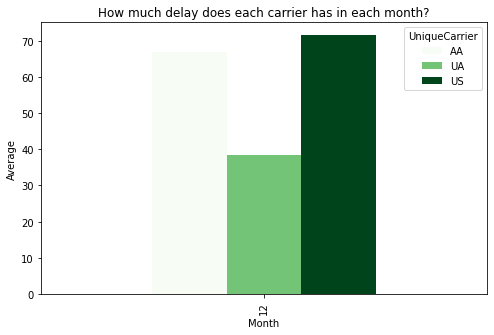

In [33]:
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Greens');
plt.xlabel('Month')
plt.ylabel('Average')
plt.title('How much delay does each carrier has in each month?')

# Airport Origin delay per day/hour

In [34]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour','DepDelay').groupby('DayOfWeek','hour').mean('DepDelay')

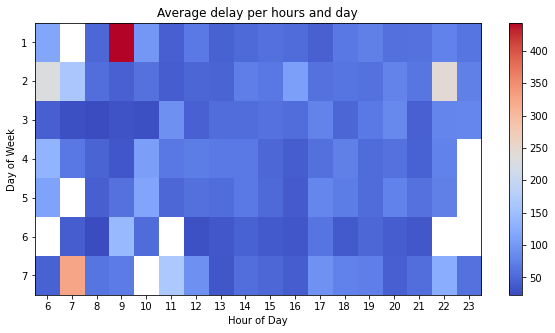

In [38]:
import matplotlib.pyplot as plt

# Assuming 'dh' is a DataFrame with the heatmap data
# Make sure that 'X' and 'Y' are arrays or lists of tick labels for the x and y axes, respectively.
# For 'X', you can use the hours of the day, and for 'Y', the days of the week.

# X and Y should have the same length as the dimensions of your data.
X = c.columns.levels[1].values
Y = c.index.values

# Create the heatmap
plt.figure(figsize=(10, 5))  # Set the figure size
plt.xticks(range(len(X)), X)  # Use the length of X as the number of tick locations
plt.yticks(range(len(Y)), Y)  # Use the length of Y as the number of tick locations
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day')
plt.imshow(Z, cmap='coolwarm', aspect='auto')  # Adjust the colormap as needed

# Display the colorbar for reference
plt.colorbar()

# Show the plot
plt.show()


In [39]:
Origin_Airport="SJC"

In [40]:
df_ORG=sqlContext.sql("SELECT * from airlineDF WHERE Origin = '"+Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")

c:\Users\markj\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


# Modeling: Logistic Regression
Logistic regression analysis is used to examine the association of (categorical or continuous) independent variable(s) with one dichotomous dependent variable. 

In [41]:
#feature selction
df_model=df_ORG
stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
model_stringIndexer = stringIndexer1.fit(df_model)
indexedOrigin = model_stringIndexer.transform(df_model)
encoder1 = OneHotEncoder(dropLast=False,inputCol="originIndex", outputCol="originVec")
ohe = encoder1.fit(indexedOrigin)
df_model = ohe.transform(indexedOrigin)

We use labeled point to make local vectors associated with a label/response.
In MLlib, labeled points are used in supervised learning algorithms and they are stored as doubles.
For binary classification, a label should be either 0 (negative) or 1 (positive).

In [42]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayOfWeek','hour','Distance','originVec'],
    outputCol = "features")
output = assembler.transform(df_model)

In [43]:
from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg
from pyspark.sql.functions import col
def as_old(v):
    if isinstance(v, ml_linalg.SparseVector):
        return mllib_linalg.SparseVector(v.size, v.indices, v.values)
    if isinstance(v, ml_linalg.DenseVector):
        return mllib_linalg.DenseVector(v.values)
    raise ValueError("Unsupported type {0}".format(type(v)))
airlineRDD=output.select(col("DepDelayed").alias("label"), col("features"))\
            .rdd\
            .map(lambda row: LabeledPoint(row.label, as_old(row.features)))

In [44]:
airlineRDD.take(2)

[LabeledPoint(1.0, [2014.0,12.0,2.0,2.0,18.0,569.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,2.0,2.0,13.0,569.0,1.0])]

In [45]:
#  Spliting dataset into train and test dtasets
trainRDD,testRDD=airlineRDD.randomSplit([0.7,0.3])

In [46]:
# Build the model
model = LogisticRegressionWithLBFGS.train(trainRDD)

# Model Evaluation

In [47]:
# Evaluating the model on testing data
labelsAndPreds = testRDD.map(lambda p: (p.label, model.predict(p.features)))
labelsAndPreds.take(2)

[(1.0, 0), (1.0, 0)]

In [48]:
trainErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(testRDD.count())
print("Training Error = " + str(trainErr))

Training Error = 0.09215017064846416


In [49]:
testRDD.take(10)

[LabeledPoint(1.0, [2014.0,12.0,4.0,4.0,8.0,2355.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,7.0,7.0,8.0,2355.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,23.0,2.0,15.0,697.0,1.0]),
 LabeledPoint(0.0, [2014.0,12.0,22.0,1.0,9.0,569.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,22.0,1.0,13.0,569.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,26.0,5.0,10.0,697.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,27.0,6.0,17.0,697.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,27.0,6.0,12.0,697.0,1.0]),
 LabeledPoint(0.0, [2014.0,12.0,27.0,6.0,7.0,569.0,1.0]),
 LabeledPoint(1.0, [2014.0,12.0,19.0,5.0,17.0,697.0,1.0])]

In [50]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)
acc1 = labelsAndPreds.map(lambda vp: ((vp[1], vp[0]), 1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

In [51]:
for x in range(len(acc)): 
    print (acc[x])

('FP', 3)
('TP', 256)
('FN', 24)
('TN', 10)


In [52]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
print("Model Accuracy for SJC:")
print(float(Accuracy*100))

Model Accuracy for SJC:
90.78498293515358
